# Hyper Parameter Optimization For XGBoost

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/XGBoost'

In [ ]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [5]:
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [6]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [12]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")


# create a pipeline
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1) )
]) 
# define the parameter grid for the XGBoost model(total 960 combinations)
param_grid = {
    'xgb__n_estimators': [200, 500],
    'xgb__max_depth': [3, 5, 6, 7, 9, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0],
    'xgb__lambda': [0.5, 1],
    'xgb__alpha': [0, 0.5]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# n_iters=6, runtime=8s
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['DFT XGBoost'] HP optimazation begin...
Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     fe...
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__alpha': [0, 0.5],
                         'xgb__colsample_bytree': [0.7, 1.0],
                         'xgb__lambda': [0.5, 1],
                         'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'xgb__max_depth': [3, 5, 6, 7, 9, 10],
                         'xgb__n_estimators': [200, 500],
                         'xgb__subsample': [0.7, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [14]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_xgb__n_estimators', 'param_xgb__max_depth',
                                 'param_xgb__learning_rate', 'param_xgb__subsample',
                                 'param_xgb__colsample_bytree', 'param_xgb__lambda', 'param_xgb__alpha',
                                 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'xgb__alpha': 0.5, 'xgb__colsample_bytree': 0.7, 'xgb__lambda': 1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 10, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
Best Cross-Validation RMSE: 0.7001


,rank_test_score,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__subsample,param_xgb__colsample_bytree,param_xgb__lambda,param_xgb__alpha,train_rmse,test_rmse
647,1,500,10,0.05,1.0,0.7,1.0,0.5,0.278019,0.700112
527,2,500,10,0.05,1.0,0.7,0.5,0.5,0.273099,0.700362
667,3,500,9,0.10,1.0,0.7,1.0,0.5,0.245542,0.700616
547,4,500,9,0.10,1.0,0.7,0.5,0.5,0.242463,0.700771
646,5,500,10,0.05,0.7,0.7,1.0,0.5,0.294954,0.701336


### Overfitting check

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.8s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:


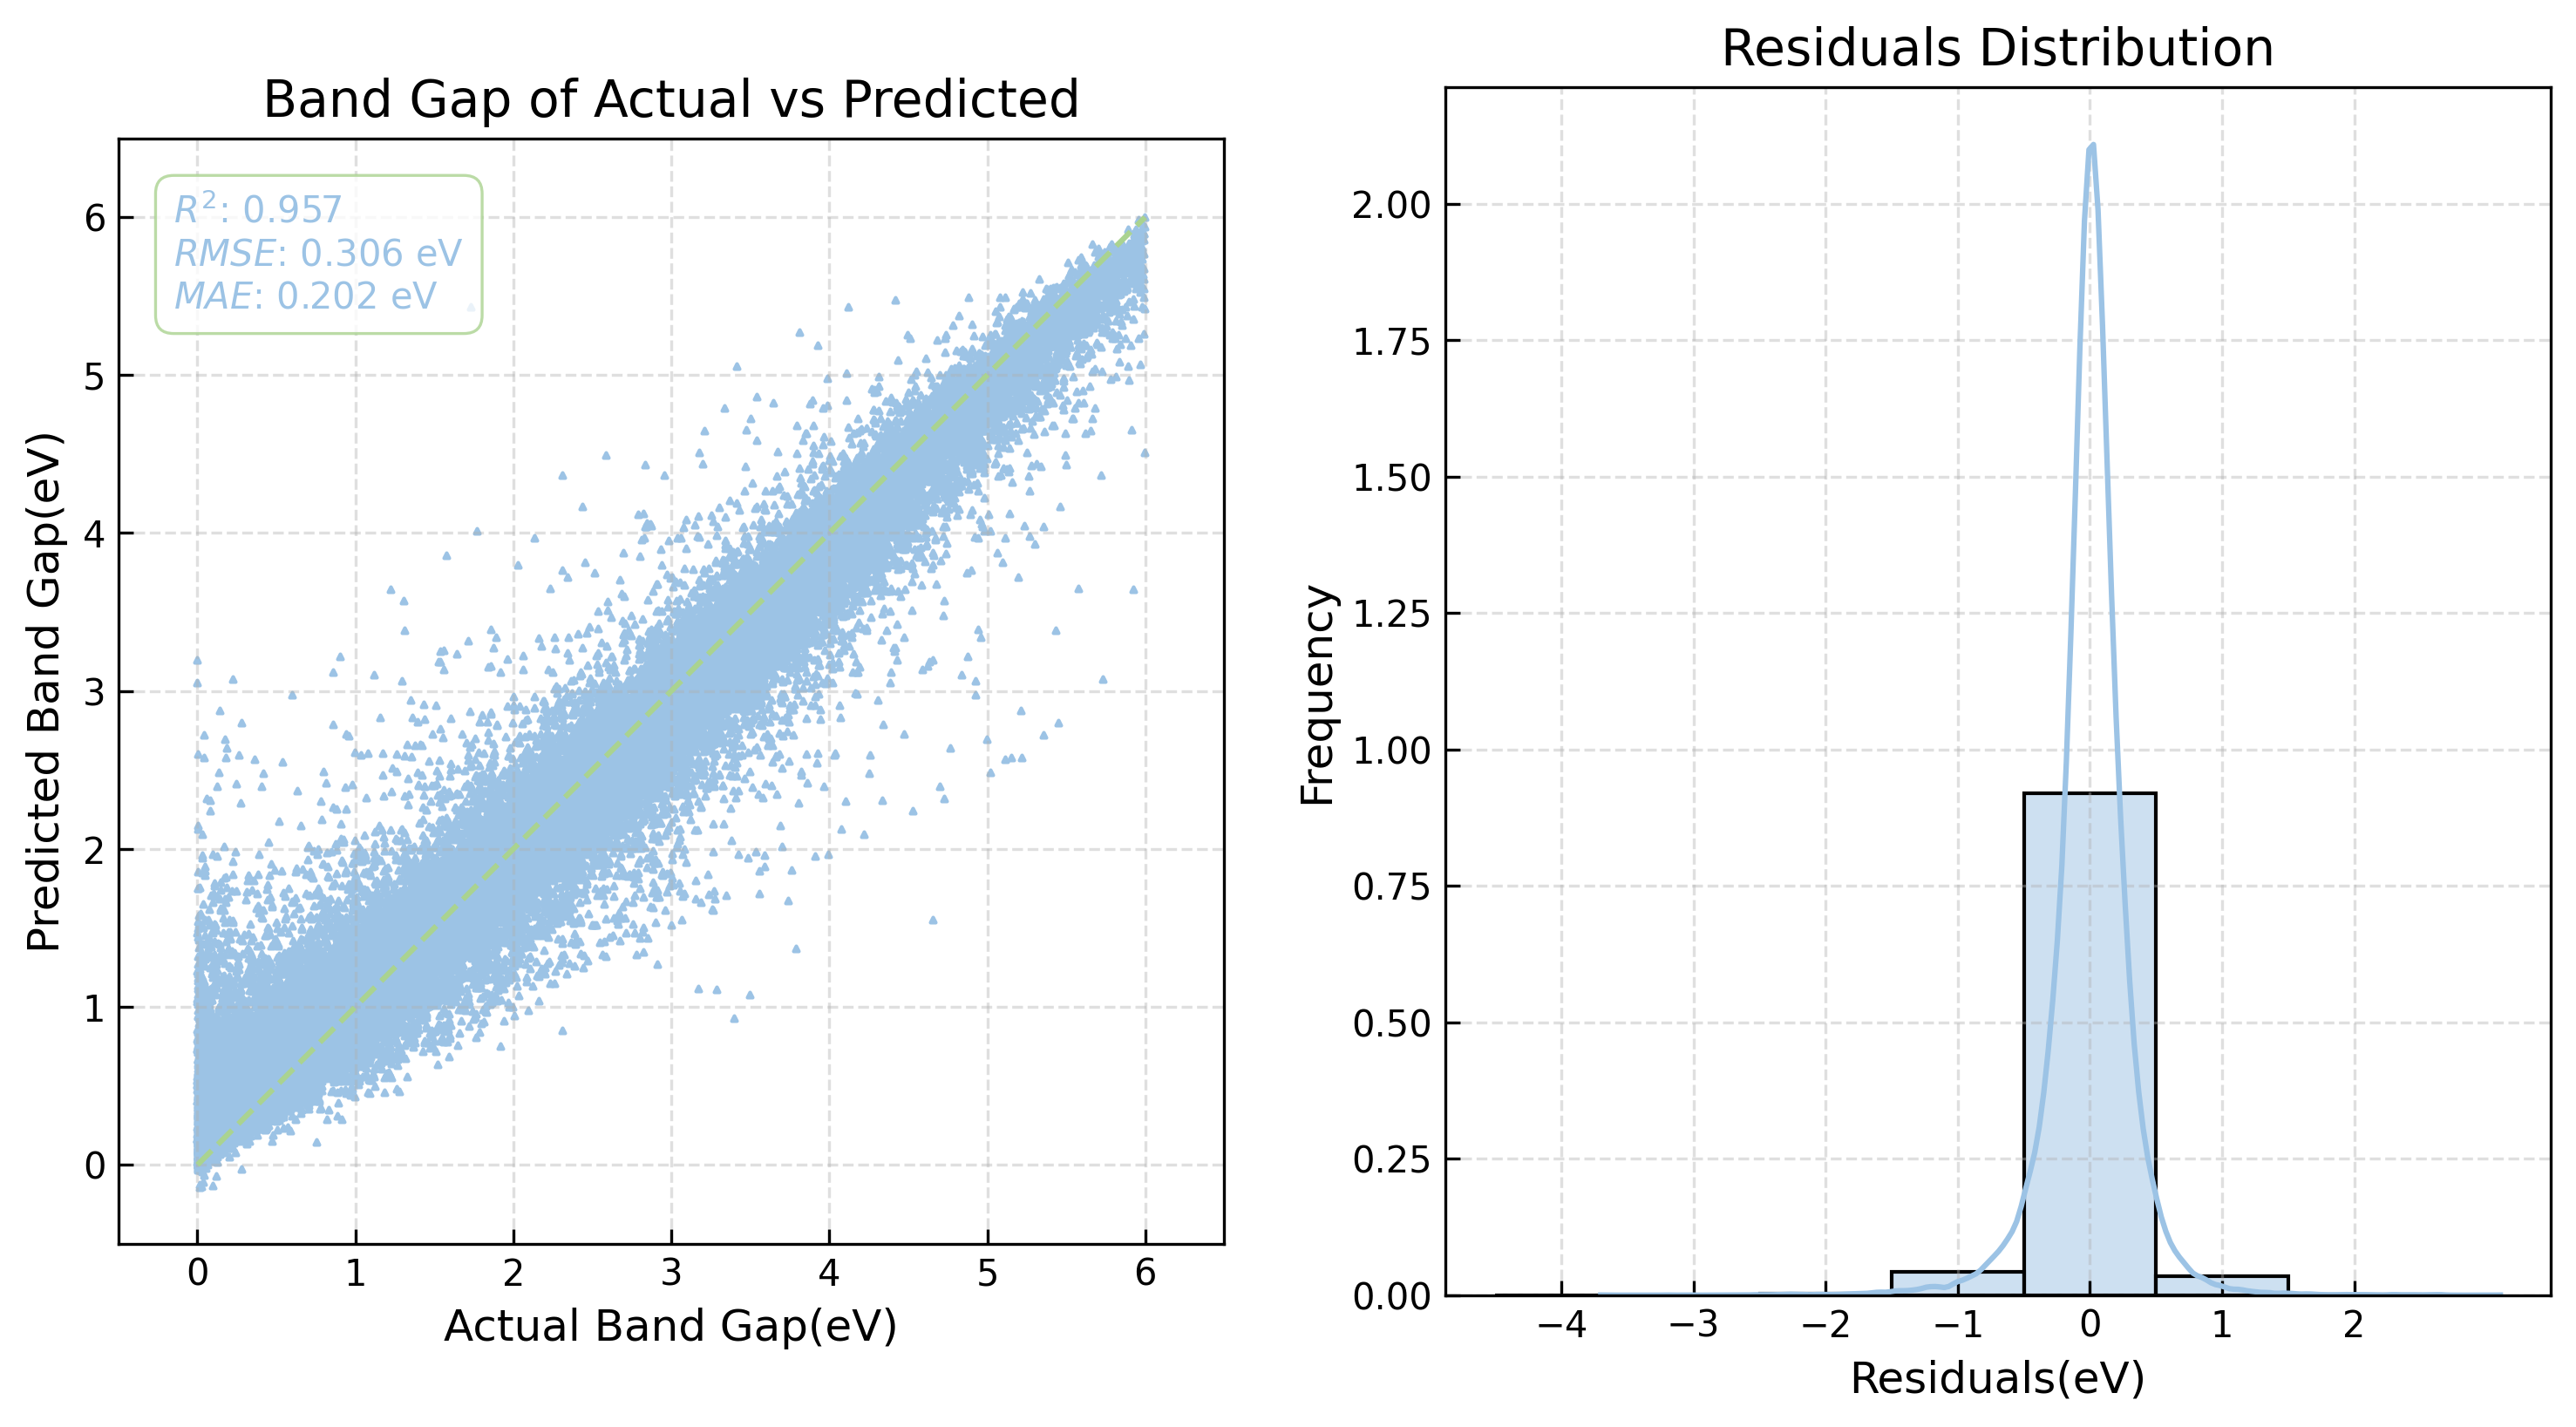


Model Evaluation Results:
Test set: R²: 0.9570 RMSE: 0.3062 MAE: 0.2022
[Test DFT -> DFT] Evaluating DFT XGBoost on DFT test set:


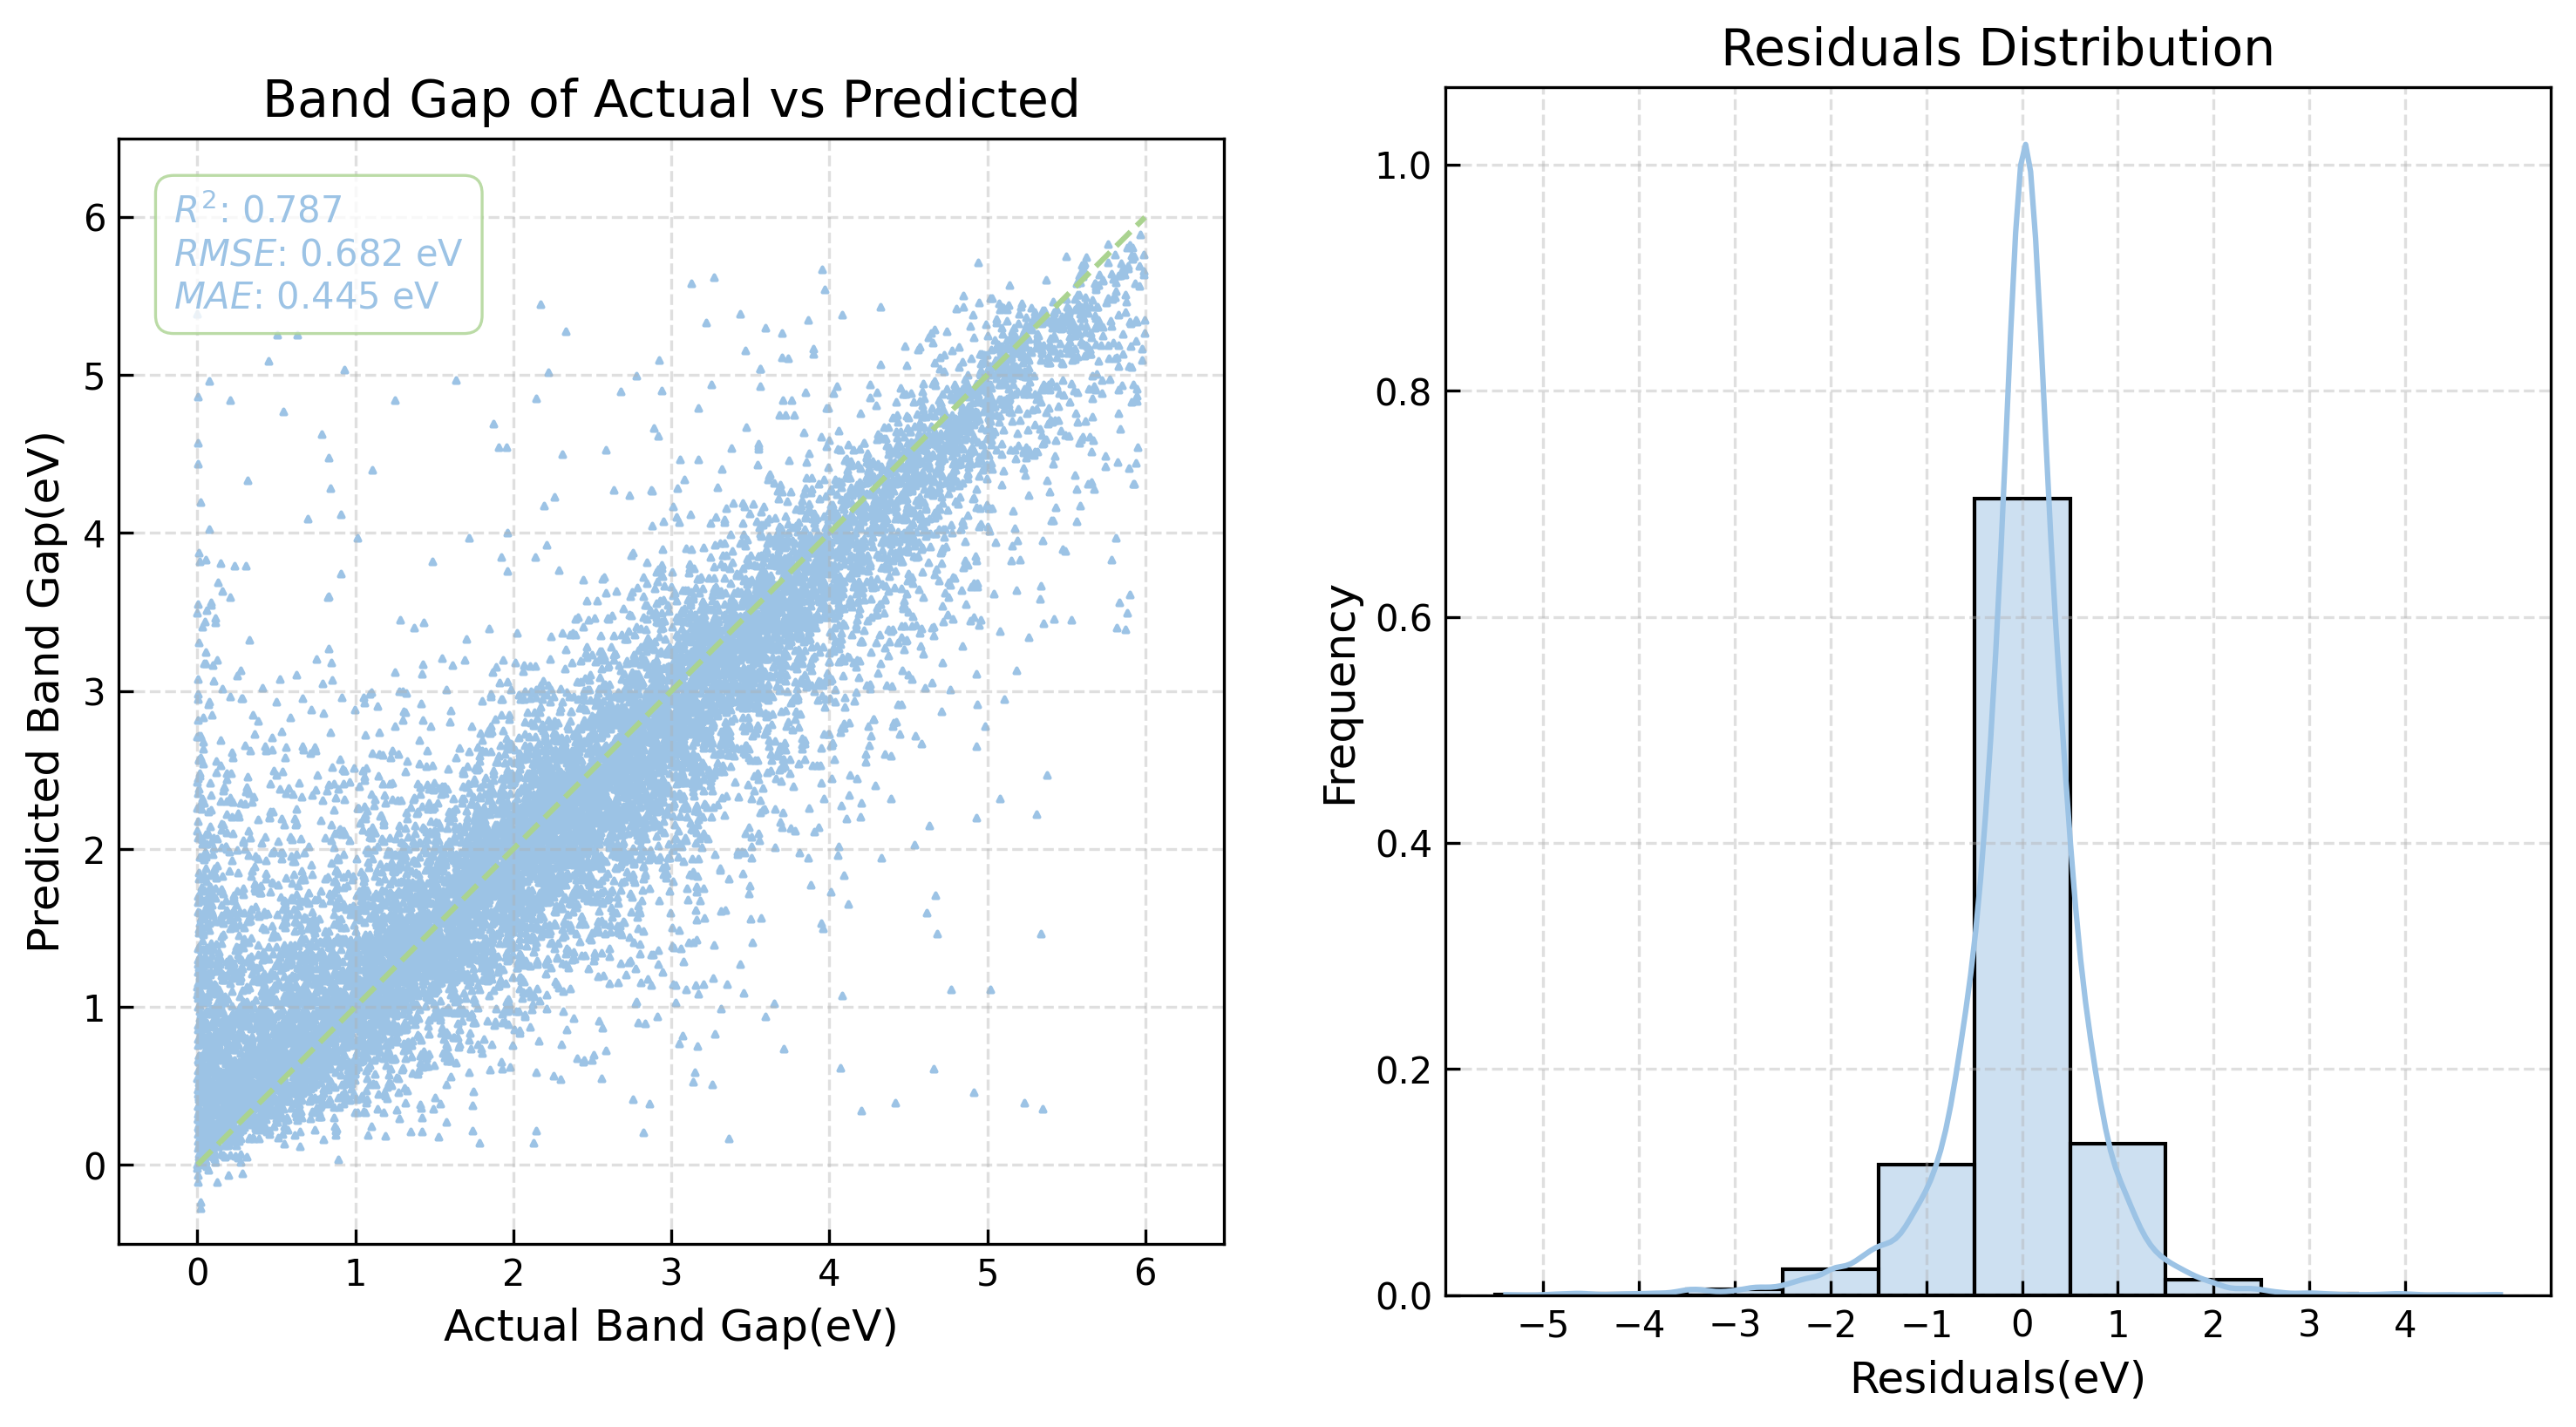


Model Evaluation Results:
Test set: R²: 0.7871 RMSE: 0.6820 MAE: 0.4449
[Test DFT -> EXP] Evaluating DFT XGBoost on EXP test set:


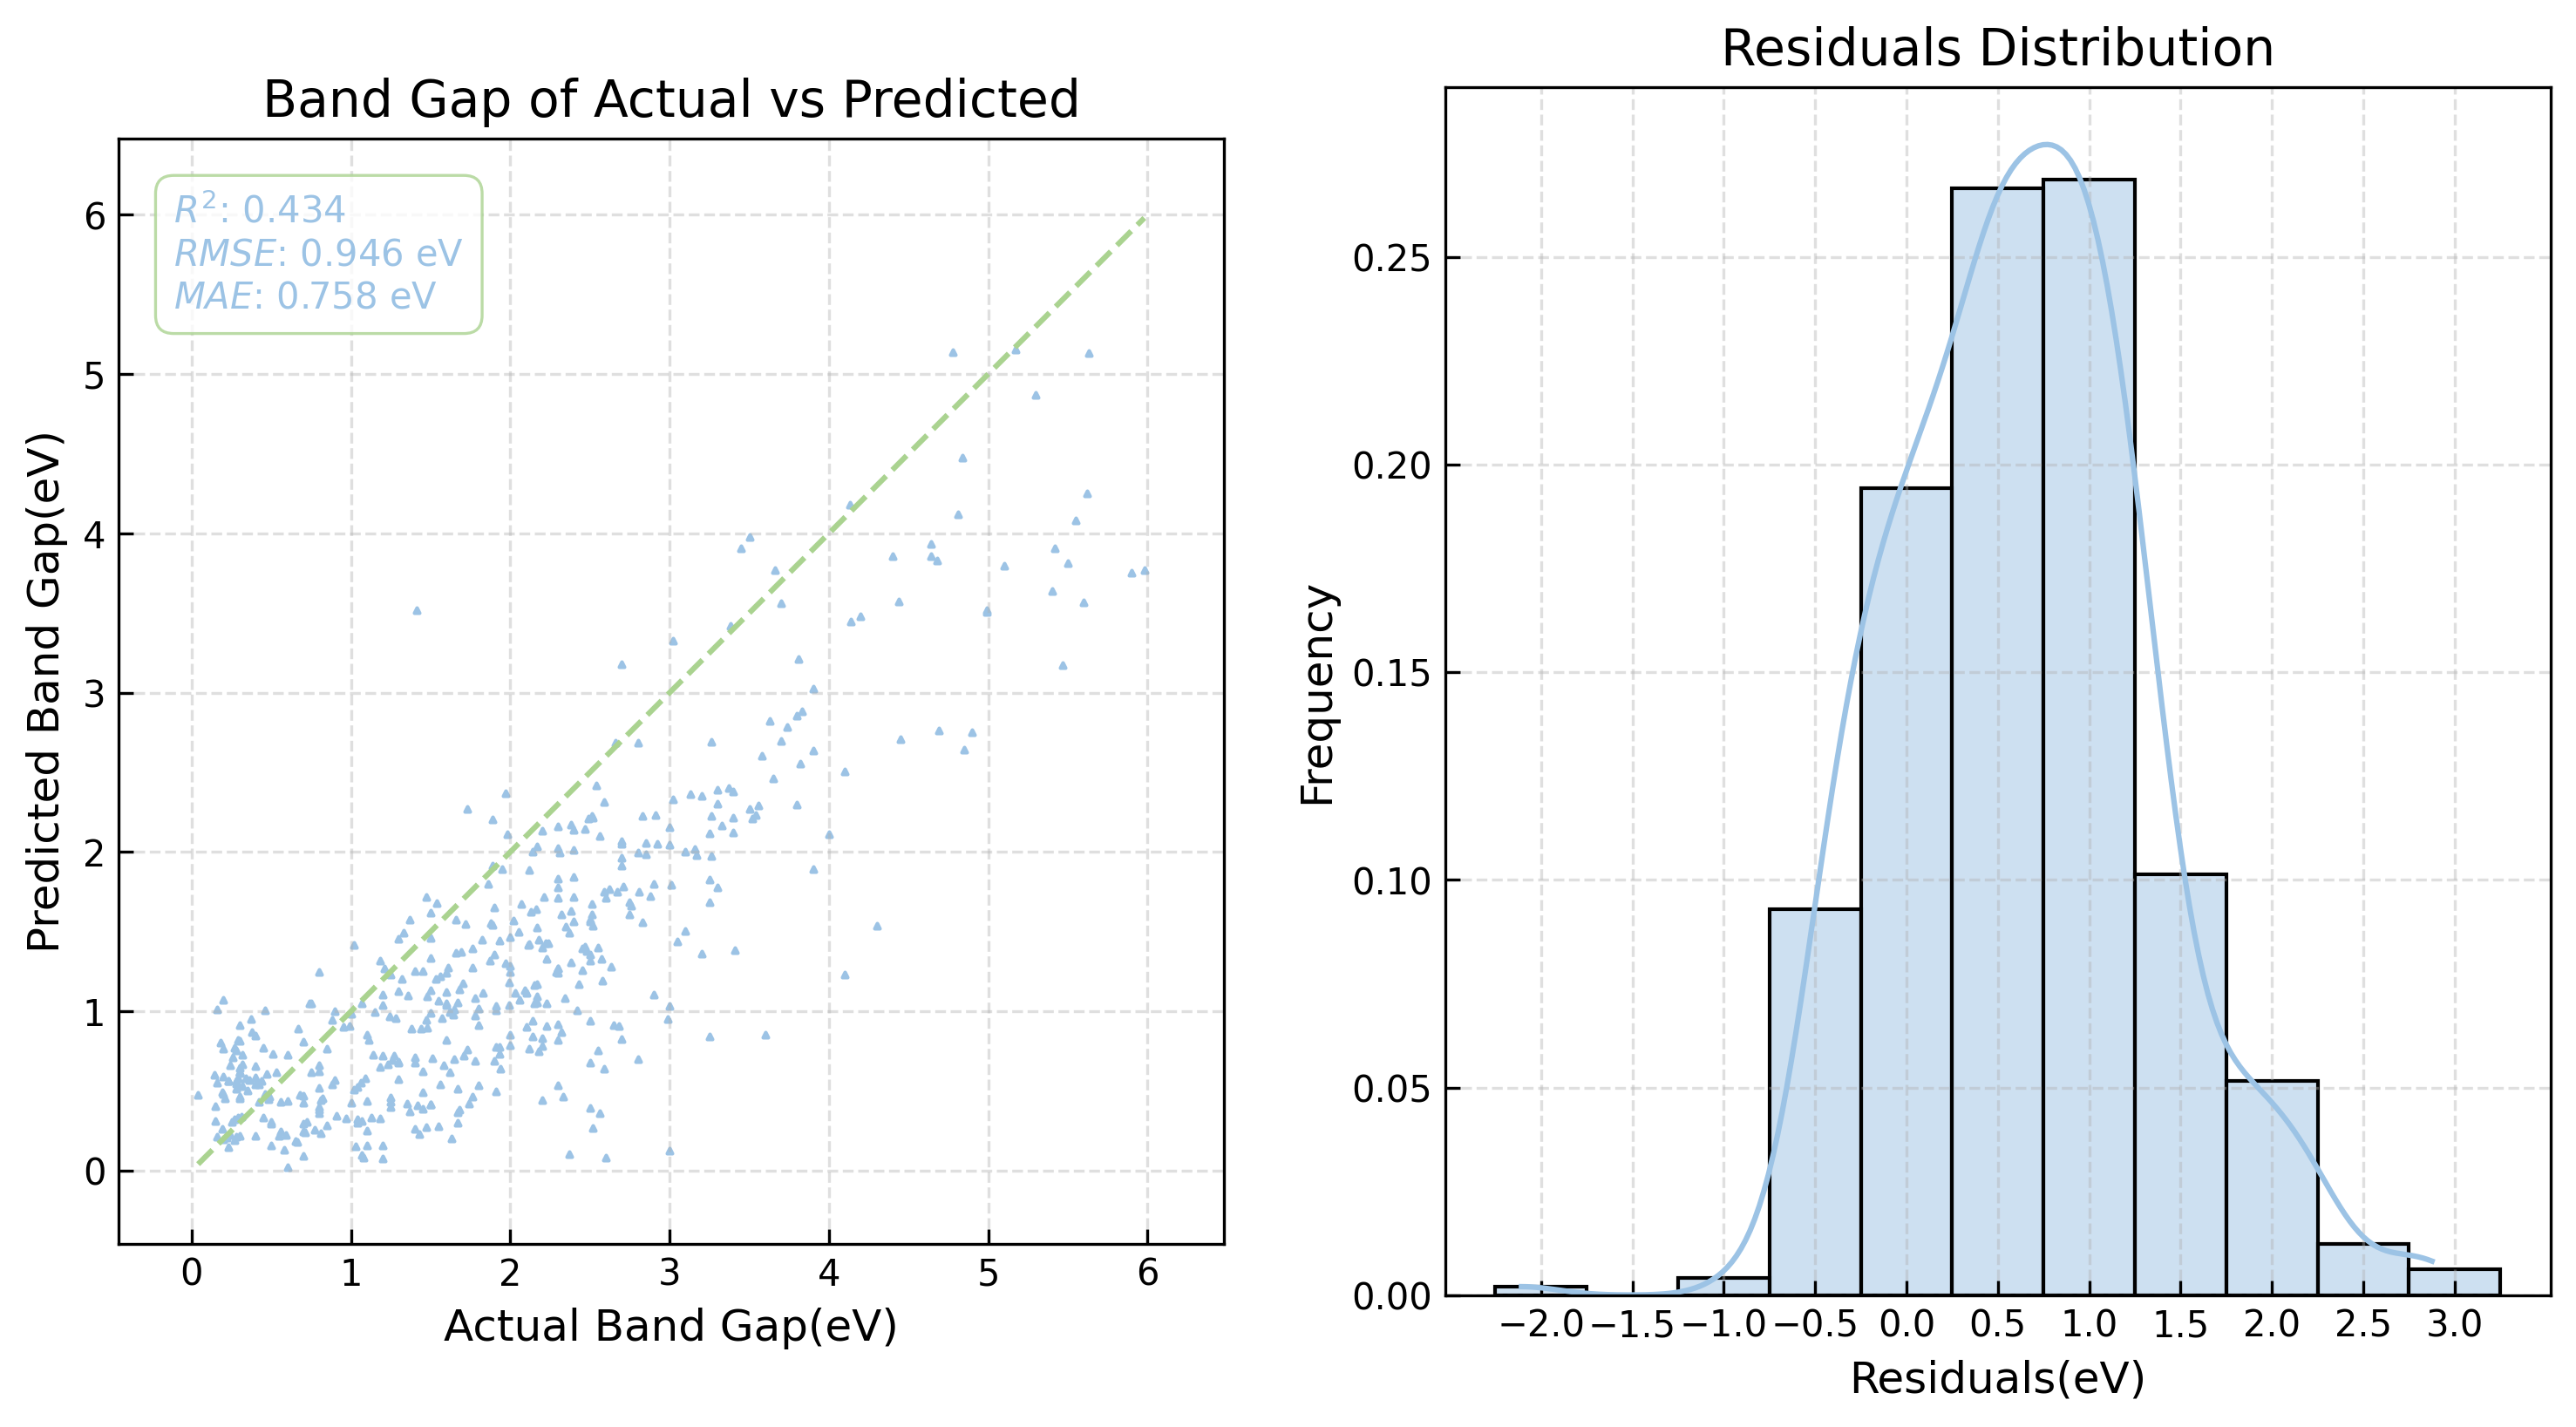


Model Evaluation Results:
Test set: R²: 0.4339 RMSE: 0.9455 MAE: 0.7584


In [16]:
# 
# Train the model with the best hyperparameters on the entire training set
xgboost_best = XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [17]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,dft,dft,0.956998,0.306212,0.202236
1,XGBoost,Test,dft,dft,0.787094,0.682035,0.444944
2,XGBoost,Test,dft,exp,0.433922,0.945503,0.758396


### EXP Model

In [19]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")

# create a pipeline
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1, verbosity=0) )
])
# define the parameter grid for the XGBoost model(total 1800 combinations)
# n_iters=90, runtime=60s
param_grid = {
    'xgb__n_estimators': [300, 500],
    'xgb__max_depth': [3, 5, 7, 9, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'xgb__subsample': [0.7, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.9, 1.0],
    'xgb__lambda': [0.5, 1],
    'xgb__alpha': [0, 0.5]
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP XGBoost'] HP optimazation begin...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     fe...
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__alpha': [0, 0.5],
                         'xgb__colsample_bytree': [0.7, 0.9, 1.0],
                         'xgb__lambda': [0.5, 1],
                         'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'xgb__max_depth': [3, 5, 7, 9, 10],
                         'xgb__n_estimators': [300, 500],
                         'xgb__subsample': [0.7, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [20]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_xgb__n_estimators', 'param_xgb__max_depth',
                                 'param_xgb__learning_rate', 'param_xgb__subsample',
                                 'param_xgb__colsample_bytree', 'param_xgb__lambda', 'param_xgb__alpha',
                                 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'xgb__alpha': 0, 'xgb__colsample_bytree': 0.7, 'xgb__lambda': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 500, 'xgb__subsample': 0.7}
Best Cross-Validation RMSE: 0.5622


,rank_test_score,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__subsample,param_xgb__colsample_bytree,param_xgb__lambda,param_xgb__alpha,train_rmse,test_rmse
219,1,500,5,0.10,0.7,0.7,1.0,0.0,0.041883,0.562182
1089,2,500,5,0.05,0.7,0.7,1.0,0.5,0.123042,0.562747
216,3,300,5,0.10,0.7,0.7,1.0,0.0,0.089353,0.562856
1569,4,500,5,0.10,0.7,1.0,0.5,0.5,0.059547,0.562897
969,5,500,5,0.10,0.7,0.7,0.5,0.5,0.063543,0.562904


### Overfitting check

####################################################################################################
[EXP - XGBoost] Training XGBoost on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.5s
Model training completed!
[Train_error] Evaluating EXP XGBoost on EXP train set:


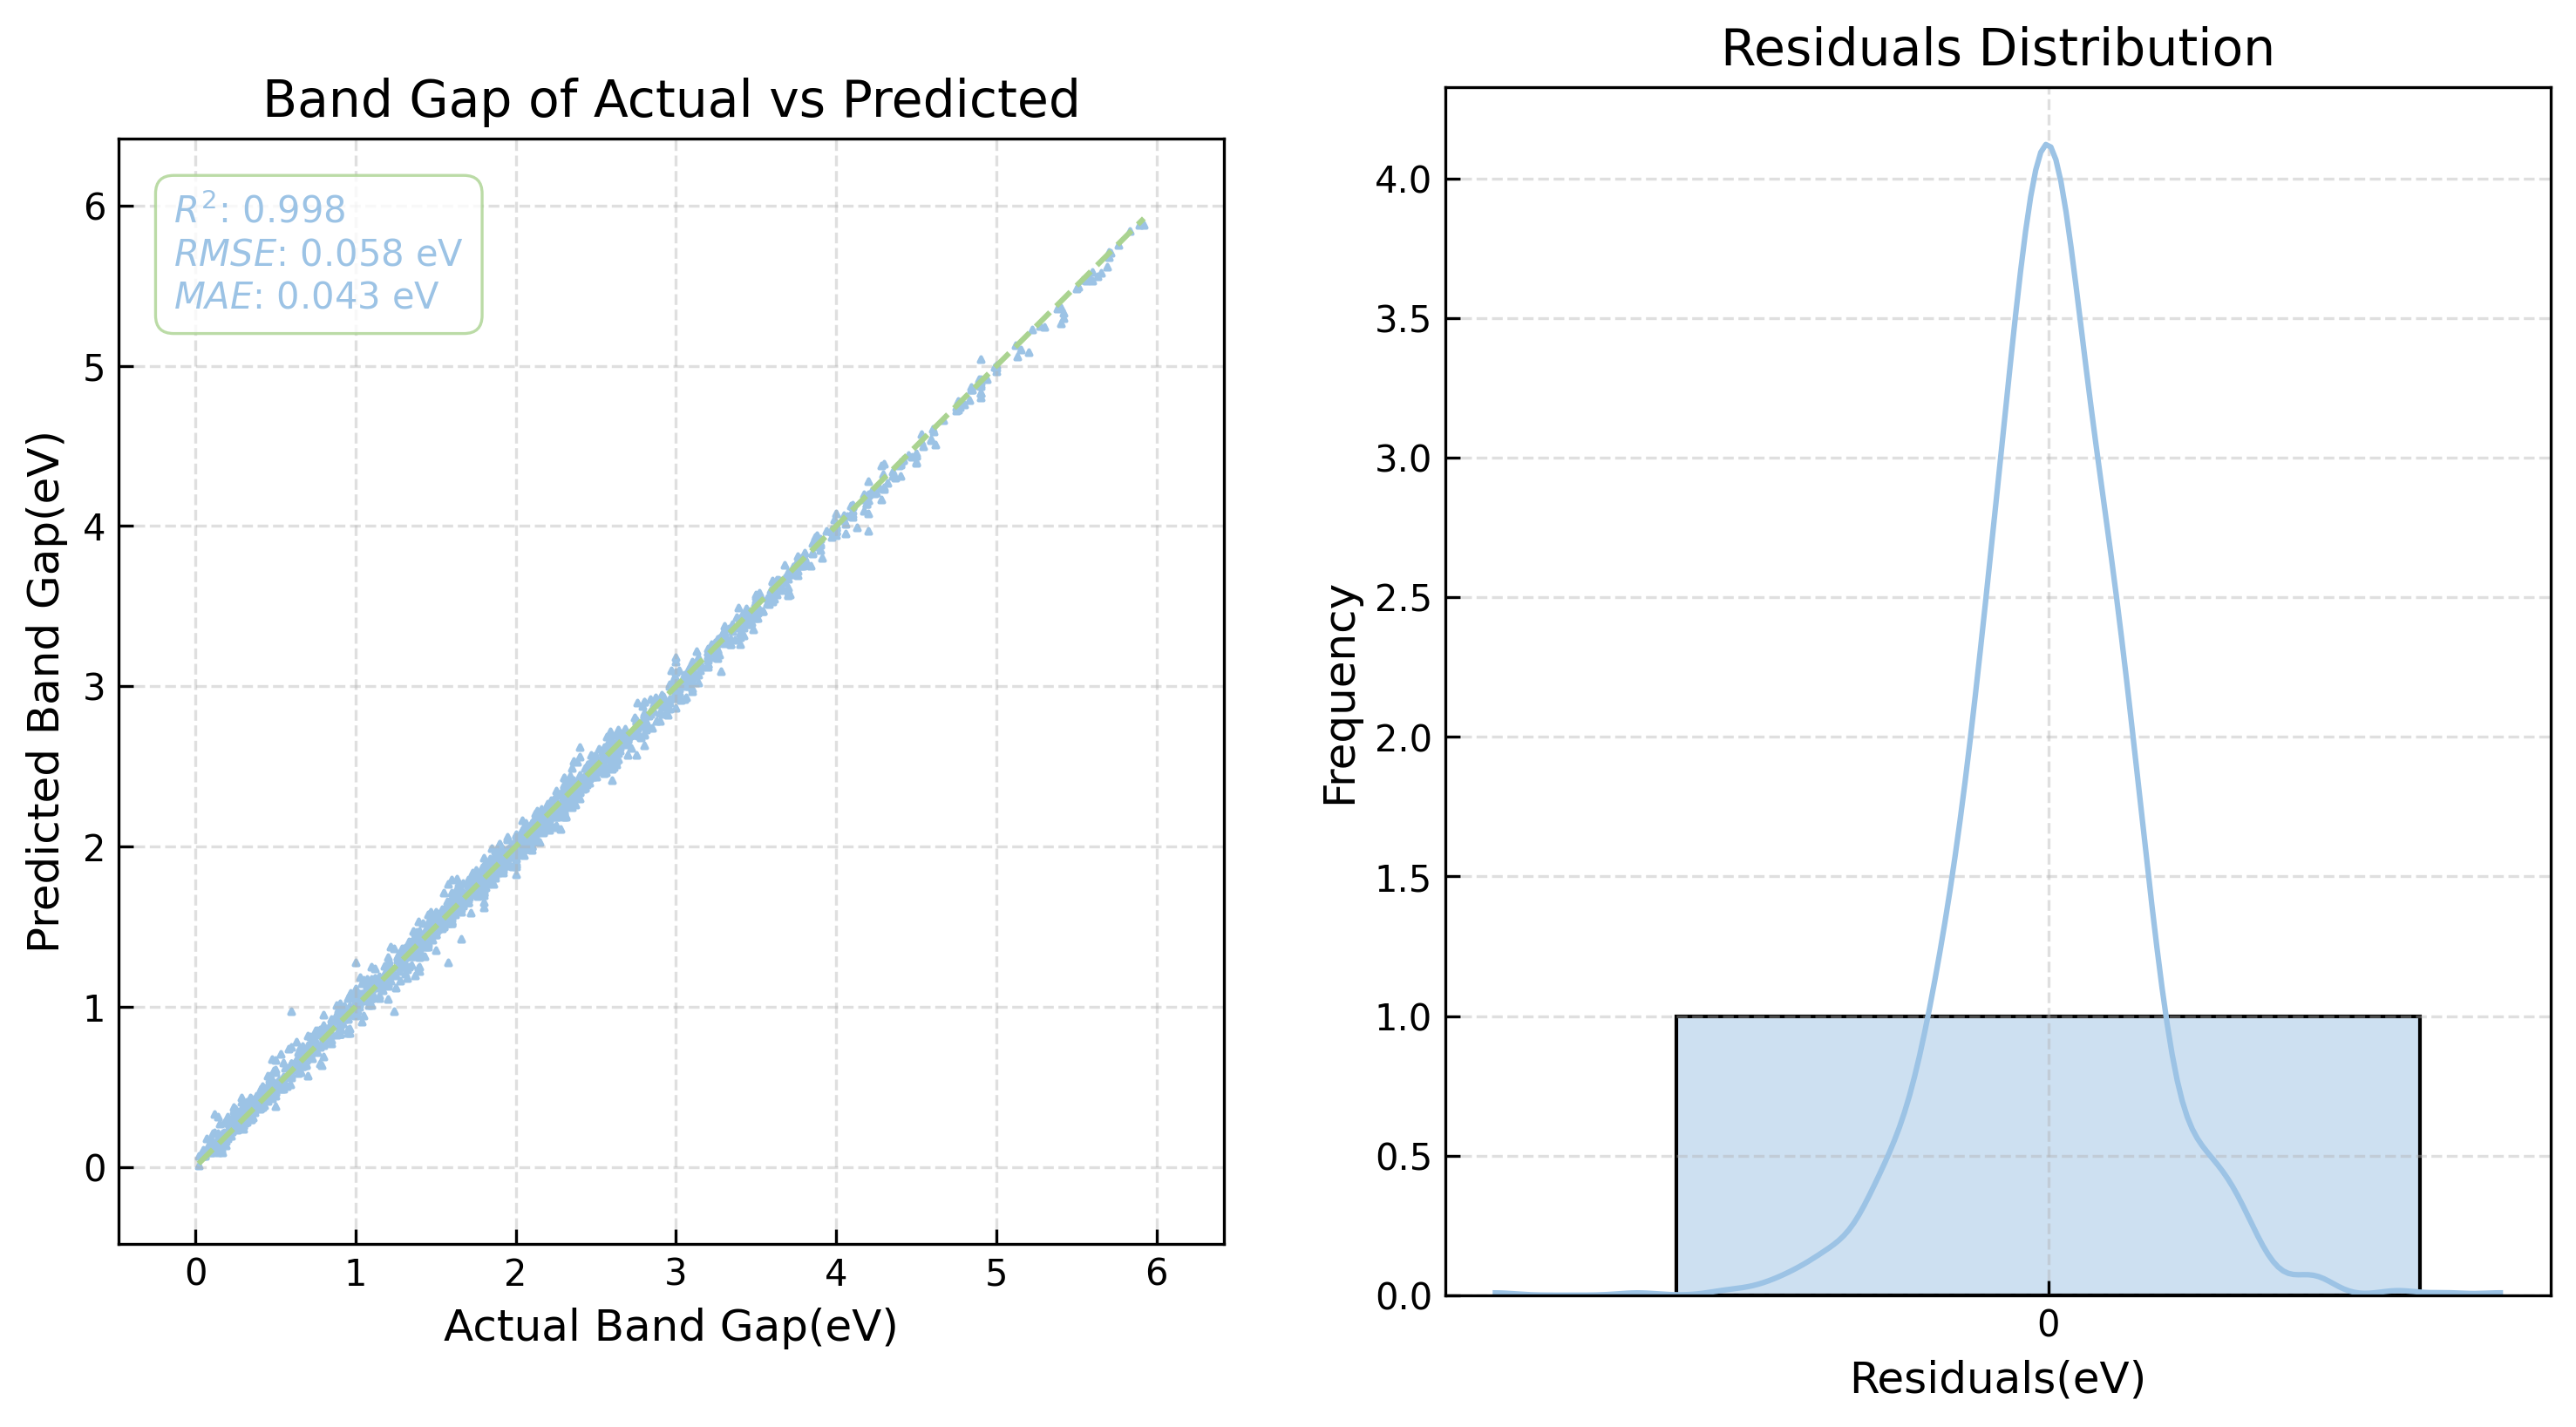


Model Evaluation Results:
Test set: R²: 0.9977 RMSE: 0.0577 MAE: 0.0428
[Test EXP -> EXP] Evaluating EXP XGBoost on EXP test set:


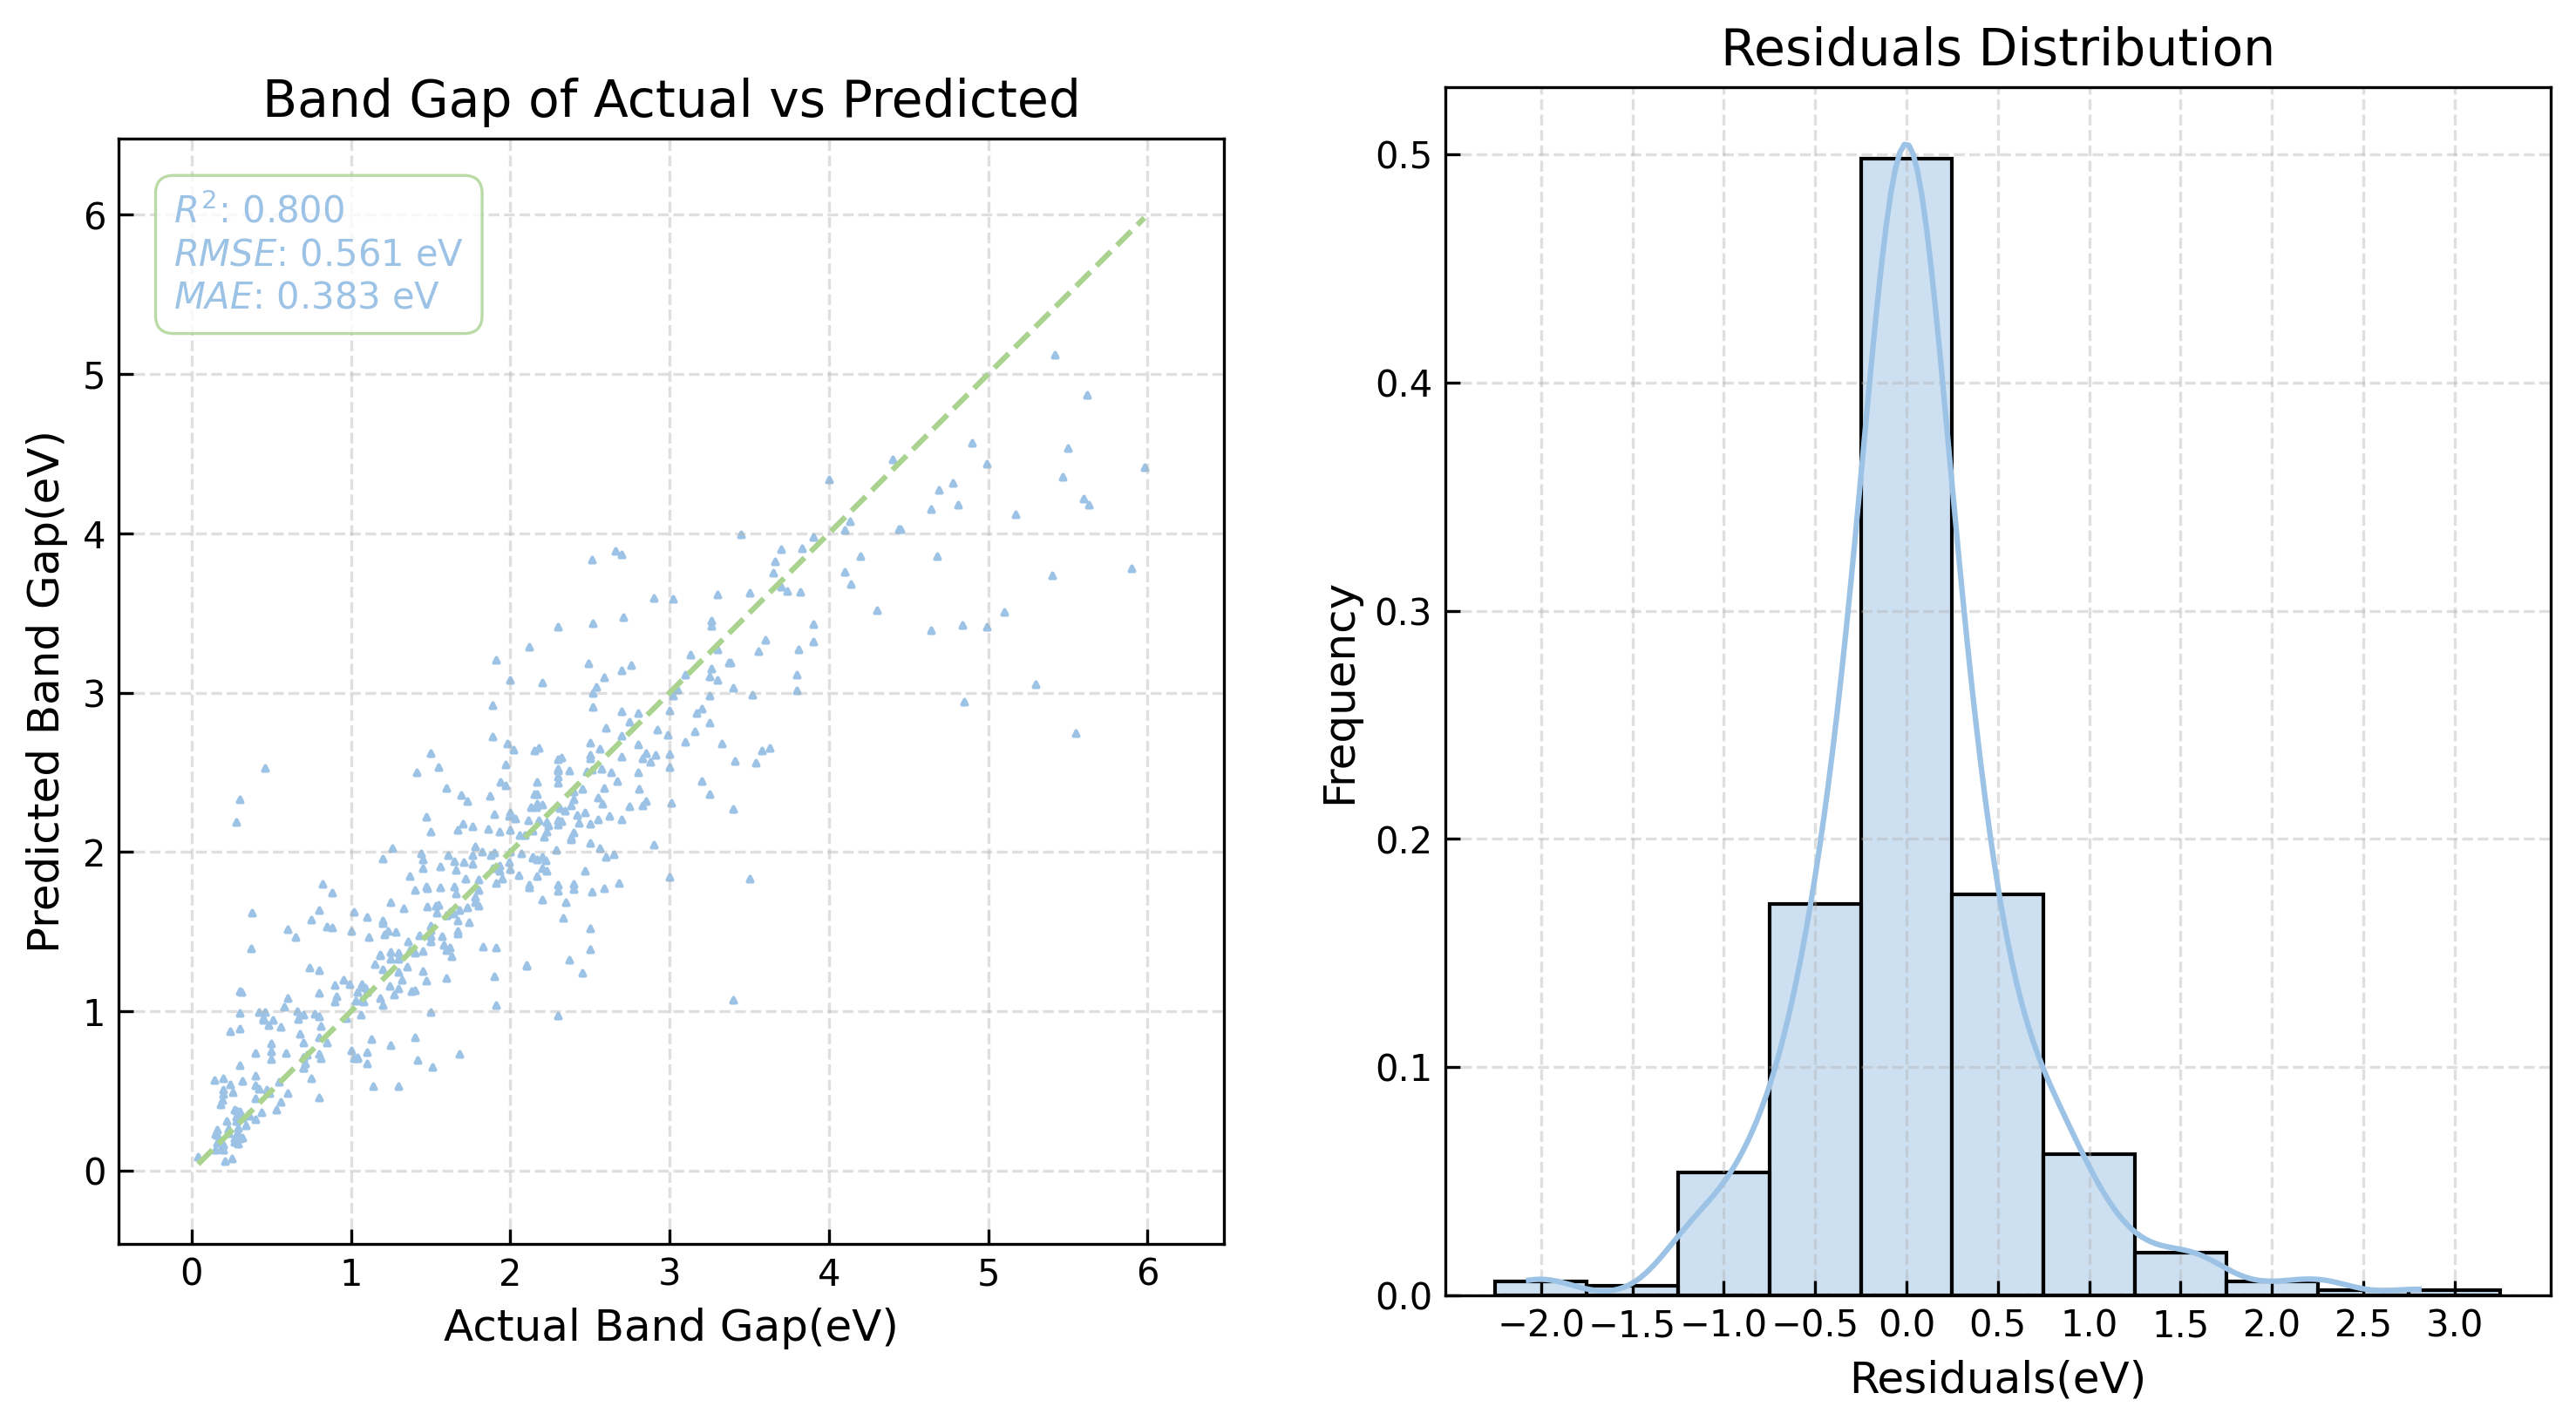


Model Evaluation Results:
Test set: R²: 0.8005 RMSE: 0.5613 MAE: 0.3832
[Test EXP -> DFT] Evaluating EXP XGBoost on DFT test set:


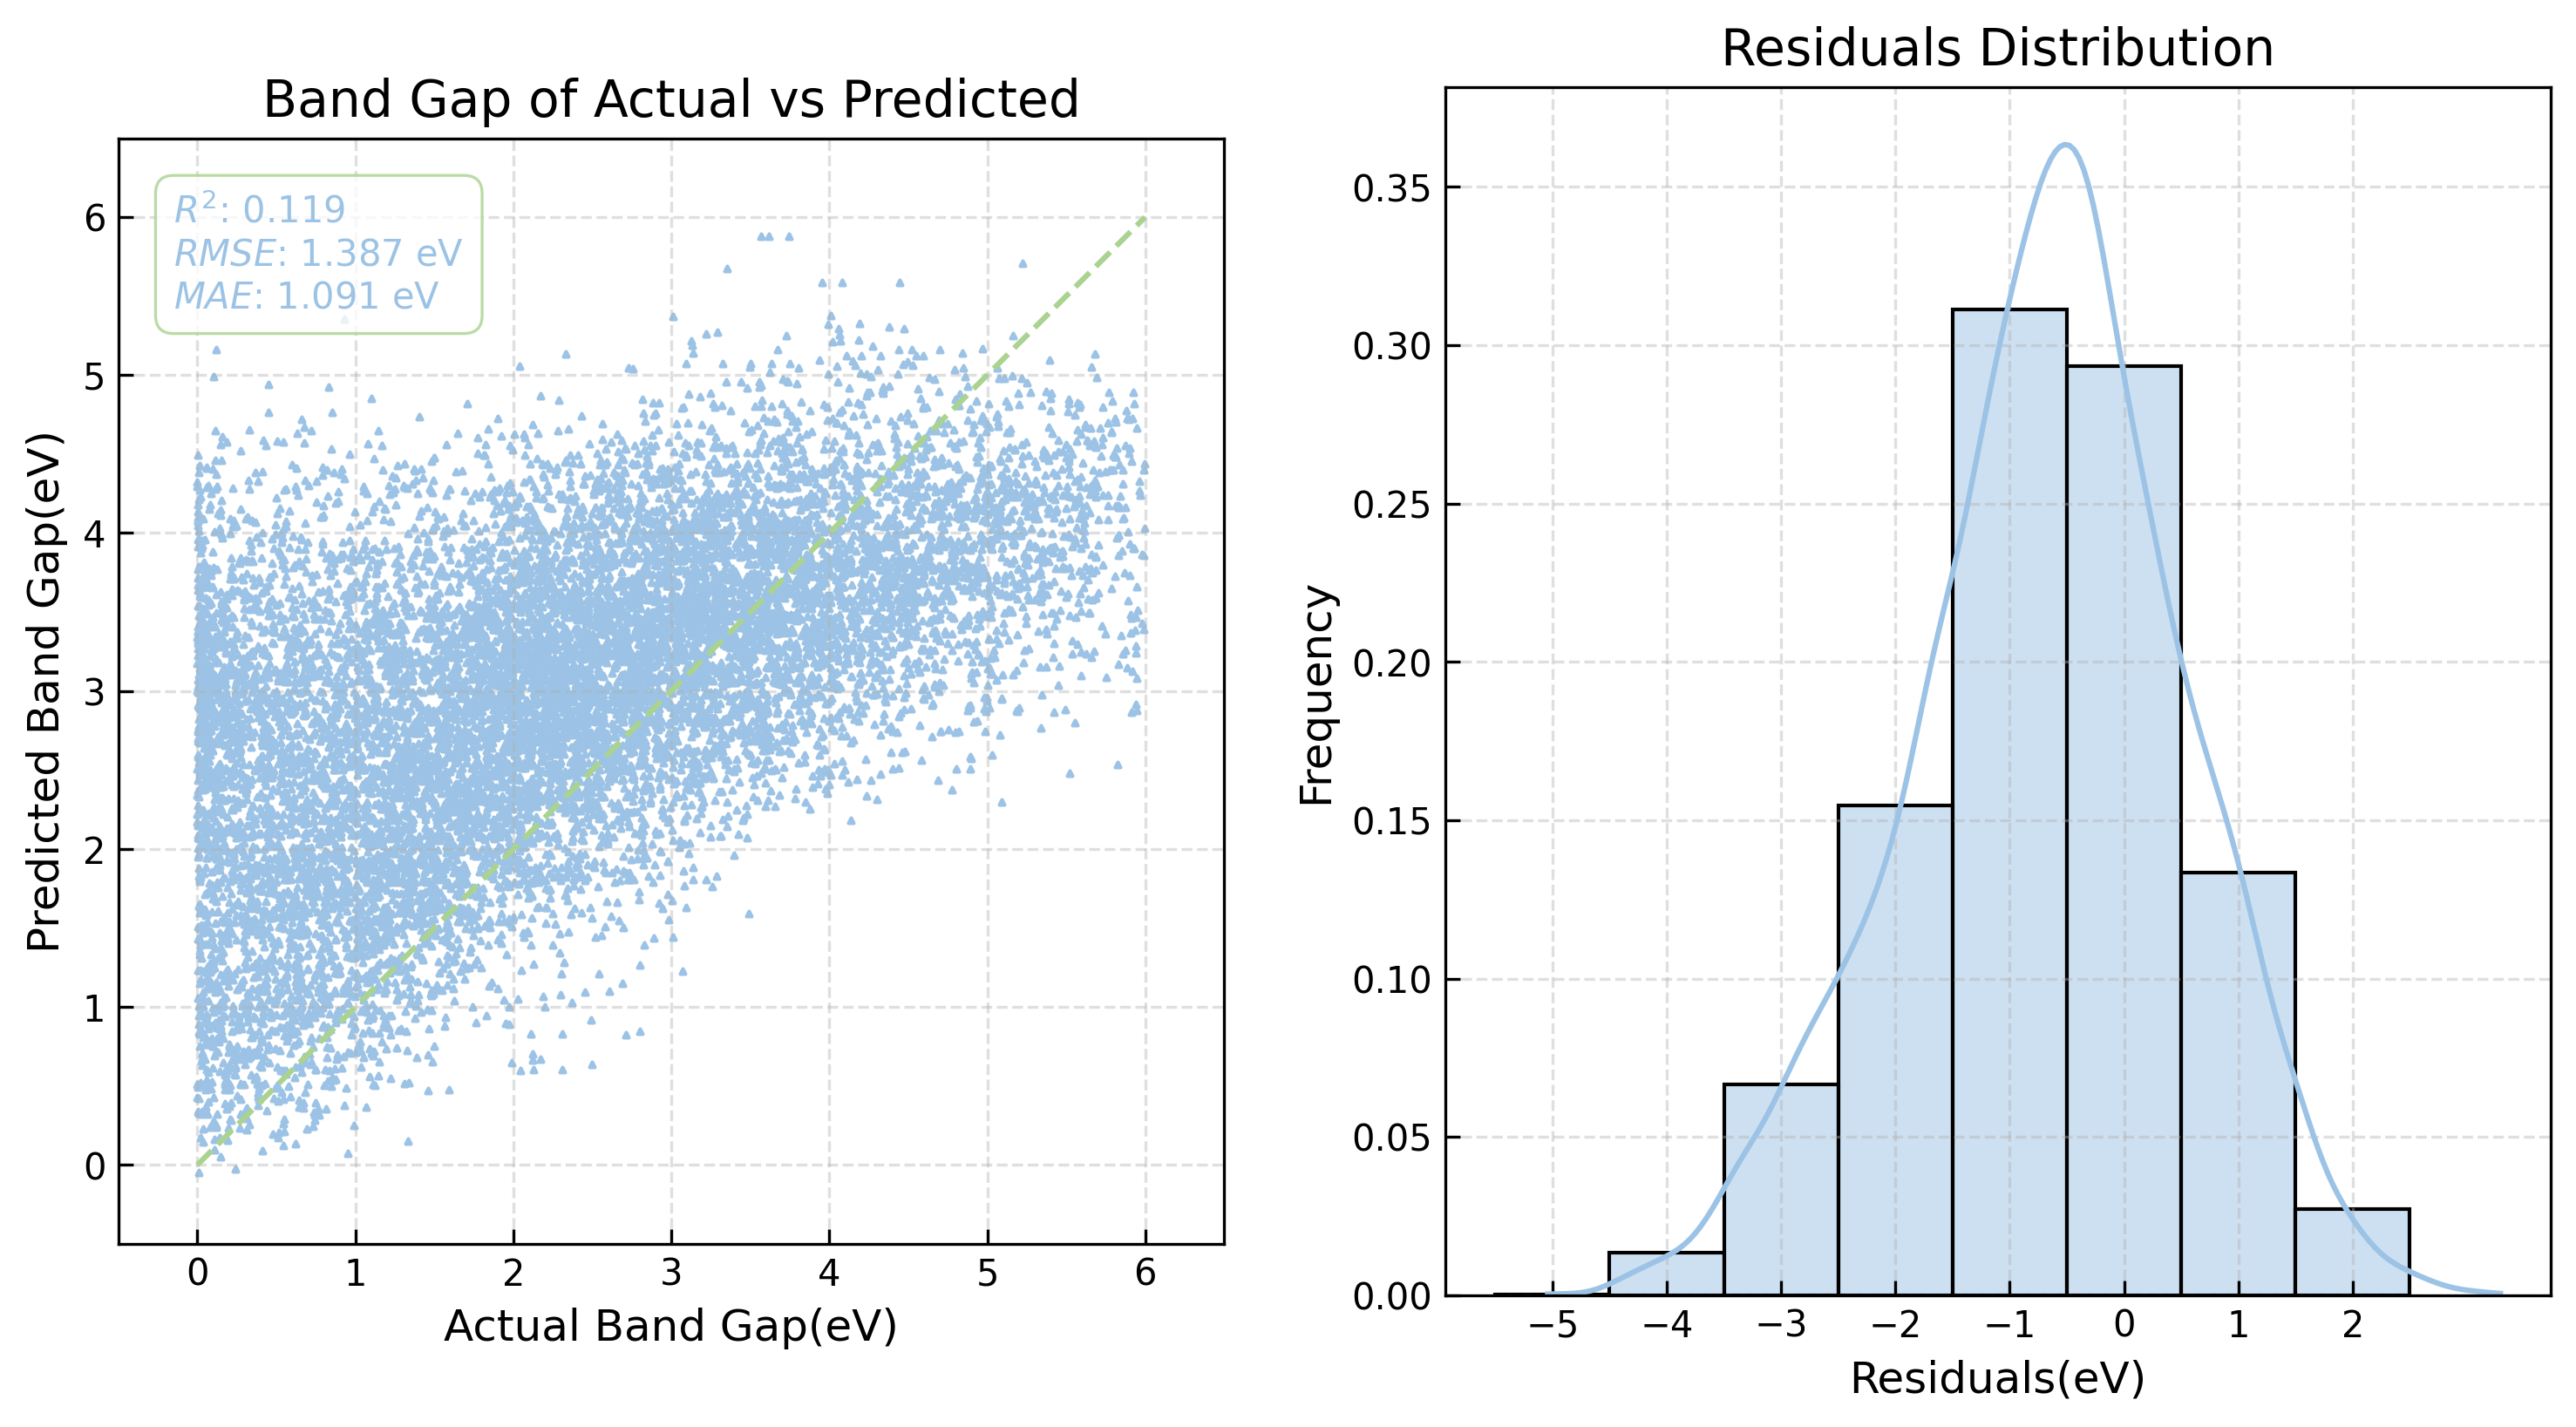


Model Evaluation Results:
Test set: R²: 0.1191 RMSE: 1.3873 MAE: 1.0914


In [21]:
# 
# Train the model with the best hyperparameters on the entire training set
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500,
    colsample_bytree=0.7, subsample=0.7, reg_lambda=1.0, alpha=0,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [22]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,exp,exp,0.997741,0.057670,0.042841
1,XGBoost,Test,exp,exp,0.800493,0.561312,0.383204
2,XGBoost,Test,exp,dft,0.119078,1.387335,1.091414
